# Assignment 1: Neuron Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Helper functions

In [2]:
def generate_spike_train(times_rates, jitter=0.):
    '''
    spike_times = generate_spike_train(times_rates, T)
    
    Creates a spike train (as an array of time stamps).
    
    Input:
    times_rates is an array or list of (t,r) pairs, so that the
        firing rate is changed to r (Hz) at time t (seconds).
        If the last firing rate is not zero, the last interval is
        extended for 1s, and then the rate goes to zero.
    jitter is a scalar that determines how much the spikes
        are randomly moved
        
    Output:
    spike_times is an array of times when spikes occurred
    
    Example: To create a spike train of 10Hz for 0.5s, followed
             by 25Hz that starts at 0.5s and ends at 2s, use
             
               generate_spike_train([[0.,10], [0.5,25], [2,0]])
    '''
    s = []
    tr = list(times_rates)
    rate_last = tr[-1][1]
    # Make sure it ends with a zero
    if rate_last != 0.:
        # If the last rate was not zero, extend for 1s and then set to 0.
        tr.append([tr[-1][0]+1., 0.])
    t = tr[0][0]
    for idx in range(0,len(tr)-1):
        t_interval = tr[idx+1][0] - t
        r = tr[idx][1]
        if r!=0:
            delta = 1. / r
            N = r * t_interval
            times = np.arange(t+delta/2., t+t_interval, delta)
            if jitter!=0.:
                times += np.random.normal(scale=delta*jitter, size=np.shape(times))
            s.extend(times)
        t = tr[idx+1][0]
    s.sort()
    return np.array(s)


def plot_spike_raster(st, y_range=None):
    '''
    plot_spike_raster(spiketimes, y_range=[0, 1.])

    Plots a spike raster plot for a list of arrays of spike times.

    Input:
      spiketimes is a list of arrays of spike times, like that returned
          by the function Stim2Spikes.
      y_range is a 2-tuple that holds the y-values that the raster ticks
          should be drawn between
    '''
    N = len(st)  # number of neurons
    
    if y_range is None:
        y_range = [0, N-1]

    #loc = np.linspace(y_range[0], y_range[1], N)
    loc = np.linspace(0, N-1, N)
    if N==1:
        bin_radius = 0.5
    else:
        bin_radius = ( loc[1] - loc[0] ) / 2.
    ctr = []
    for n in range(N):
        nspikes = len(st[n])
        y = [ [loc[n]-bin_radius]*nspikes , [loc[n]+bin_radius]*nspikes ]
        plt.plot(np.vstack((st[n],st[n])), y, color=np.random.rand(3))
    plt.ylim([y_range[0]-bin_radius, y_range[-1]+bin_radius])
    plt.xlabel('Time (s)')
    plt.ylabel('Neuron index')
    return


def spikes_between(spiketrain, t_start, t_end):
    '''
     numspikes = spikes_between(spiketrain, t_start, t_end)

     Returns the number of times between t_start and t_end.
     Specifically, it counts a spike if it occurred at t, where
     t_start <= t < t_end
    
     Inputs:
       spiketrain   array-like list of spike times
       t_start      start time
       t_end        end time
       
     Output:
       numspikes    number of spikes, where t_start <= t < t_end
    '''
    sp_bool = np.logical_and( np.array(spiketrain)>=t_start, np.array(spiketrain)<t_end )
    return np.sum(sp_bool)

def random_array(n):
    '''
     w = random_array(n)
     
     Returns an array of n random numbers between 0 and 1.
     Note: The values are smoothed.
    '''
    a = np.random.random(size=(n,))
    b = np.zeros_like(a)
    omega = max(min(int(n/3.), 7), 1)
    b[:omega] = 1.
    b /= np.sum(b)
    return np.real(np.fft.ifft(np.fft.fft(a)*np.fft.fft(b)))

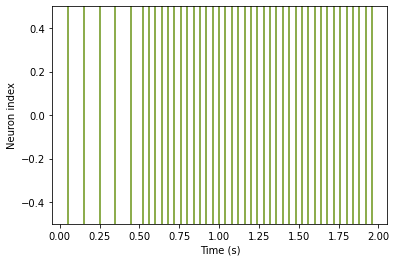

In [3]:
st = generate_spike_train([[0.,10], [0.5,25], [2,0]])
plot_spike_raster([st])

# Classes

## `Neuron` class
This is the base class for different types of neurons.

In [4]:
class Neuron(object):
    '''
     neur = Neuron()
     
     This is an abstract base class for Neuron objects.   
    '''
    def __init__(self):
        self.t = 0.       # current time
        self.axon = []    # list of outgoing connections
        
    def slope(self):
        return 0.
        
    def step(self, dt):
        raise NotImplementedError
        
    def send_spike(self, n=1):
        for a in self.axon:
            a.transmit(n)


## `Synapse` class
This class represents a connection between two neurons.

In [5]:
class Synapse(object):
    '''
     The Synapse class represents a connection between a pre-synaptic neuron and
     post-synaptic neuron. This class implements the presence and strength (weight)
     of the connection, but does NOT model the dynamics of the connection.
    '''
    def __init__(self, pre, post, w):
        self.pre = pre               # pre-synaptic Neuron object
        self.post = post             # post-synaptic Neuron object
        self.pre.axon.append(self)   # record this synapse in the pre-syn neuron
        self.w = w                   # connection weight
        
    def transmit(self, n=1):
        '''
         syn.transmit(n=1)
         
         Transmit n spikes through this synapse, from the
         pre-syn neuron to the post-syn neuron. Each spike sends
         one unit of activity, multiplied by the connection weight.
        '''
        self.post.receive_current(n*self.w)

## `InputNeuron` class
Derived from the `Neuron` class, this class is for generating input to feed into a network.

In [6]:
class InputNeuron(Neuron):
    '''
     InputNeuron(spiketrain)

     Constructor for InputNeuron class.

     InputNeuron is a class of neuron that can be used to inject spikes into
     the network. When involved in a simulation, an InputNeuron will generate
     spikes at the times specified during its construction.

     Inputs:
       spiketrain is an array or list of spike times
    '''    
    def __init__(self, spiketrain):
        super().__init__()
        self.spikes = np.array(spiketrain)

    def step(self, slopes, dt):
        n_spikes = spikes_between(self.spikes, self.t, self.t+dt)
        self.t += dt
        if n_spikes>0:
            self.send_spike(n_spikes)


## `LIFNeuron` class
Derived from the `Neuron` class, this class implements the Leaky Integrate-and-Fire (LIF) neuron.

In [7]:
class LIFNeuron(Neuron):

    def __init__(self, Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05):
        '''
         LIFNeuron(Tau_m=0.02, Tau_ref=0.002, Tau_s=0.05)
        
         Constructor for LIFNeuron class
        
         Inputs:
           Tau_m   membrane time constant, in seconds (s)
           Tau_ref refractory period (s)
           Tau_s   synaptic time constant (s)
        '''
        super().__init__()
        # self.t and self.axon are defined in the super-class, Neuron.
        self.tau_m = Tau_m      # membrane time constant
        self.tau_ref = Tau_ref  # refractory period
        self.tau_s = Tau_s      # synaptic time constant
        self.v = 0.             # sub-threshold membrane potential (voltage)
        self.s = 0.             # post-synaptic current (PSC)
        
        self.weighted_incoming_spikes = 0.  # weighted sum of incoming spikes (for one time step)
        self.ref_remaining = 0. # amount of time remaining in the refractory period
        
        # For plotting
        self.v_history = []     # records v over time
        self.s_history = []
        self.spikes = []        # list of times when this neuron spiked
    
    def slope(self):
        '''
         LIFNeuron.slope()
        
         Evaluates the right-hand side of the differential equations that
         govern v and s. This function does not include incoming spikes.
         
         Output
          [dvdt, dsdt]  the slopes, in a list
        '''
        dvdt = ( self.s - self.v ) / self.tau_m
        dsdt = -self.s / self.tau_s
        
        return [dvdt, dsdt]
        
        
    def step(self, slopes, dt):
        '''
         LIFNeuron.step(dt)
        
         Updates the LIF neuron state by taking an Euler step in v and s.
         The length of the step is dt seconds.
         
         Input
          slopes   list-like, containing the slopes of v and s
          dt       time step (in seconds)
          
         If v reaches the threshold of 1, the neuron fires an action potential
         (spike). Linear interpolation is used to estimate the time that v=1.
         The spike time is appended to the list self.spikes, and v
         is set to zero. After a spike, the neuron is dormant for self.tau_ref
         seconds.
        '''
        dvdt, dsdt = slopes
        # Update input current, included newly-arrived spikes
        self.s += dt*dsdt + self.weighted_incoming_spikes/self.tau_s
        
        v_previous = self.v
        t = self.t
        dt_integrate = dt
        
        # Implement refractory period
        if dt-self.ref_remaining>0:
            dt_integrate = max(0, dt-self.ref_remaining)
            t = self.t + self.ref_remaining
            self.v += dt_integrate*dvdt  # Euler step
            self.ref_remaining = 0
        else:
            self.v = 0.
            self.ref_remaining -= dt
        
        # Detect spike: if v reaches 1, spike
        if self.v>=1.0:
            # SPIKE!

            # Interpolate spike time
            v0 = v_previous
            v1 = self.v
            tstar = t + dt_integrate * (1.-v0) / (v1-v0)
            self.spikes.append(tstar)  # Record spike time

            self.v = 1.  # Set v to 1 (or zero)

            self.ref_remaining = self.tau_ref - (dt - (tstar-self.t))
            
            # Broadcast the spike to downstream neurons
            self.send_spike()

        # Store v (for plotting), and reset incoming spike accumulator
        self.v_history.append(self.v)
        self.s_history.append(self.s)
        self.weighted_incoming_spikes = 0.
        self.t += dt
        
    def receive_current(self, c):
        '''
         LIFNeuron.receive_current(c)
        
         Registers the arrival of spikes from a synapse.
        
         It is sufficient to add all spike-induced currents together to tabulate
         the total incoming current (from all presynaptic neurons). The
         member variable self.weighted_incoming_spikes keeps track of all
         the incoming current for a time step.
        
         Input:
           c    incoming current
        '''
        self.weighted_incoming_spikes += c
        
        
    def __repr__(self):
        '''
         print(neur)
         
         Prints the current time, membrane potential, input current, and
         remaining refractory time.
        '''
        s = f'{self.t:6.4f}s: s={self.s:5.3f}, v={self.v:6.4f}, ref remaining={self.ref_remaining:7.5f}s'
        return s

## `SpikingNetwork` class
This class represents a collection of neurons and their connections to each other. Add neurons, connect them, and then simulate the network.

In [8]:
class SpikingNetwork(object):
    
    def __init__(self):
        '''
        SpikingNetwork()
        
        Constructor for SpikingNetwork class.
        
        The SpikingNetwork class contains a collection of neurons,
        and the connections between those neurons.
        '''
        self.neur = []         # List of neurons (of various kinds)
        self.t_history = []    # List of time stamps for the Euler steps
                               # (Useful for plotting)
            
    def add_neuron(self, neur):
        '''
        SpikingNetwork.add_neuron(neuron)
        
        Adds a neuron to the network.
        
        Input:
         neuron is an object of type LIFNeuron or InputNeuron
        '''
        self.neur.append(neur)
        
    def connect(self, pre, post, w):
        '''
        SpikingNetwork.connect(pre, post, w)
        
        Connects neuron 'pre' to neuron 'post' with a connection
        weigth of w.
        
        where
         pre    is the pre-synaptic neuron object,
         post   is the post-synaptic neuron object, and
         weight is the connection weight.
        '''
        syn = Synapse(pre, post, w)
        
    def simulate(self, T, dt):
        '''
        SpikingNetwork.simulate(T, dt)
        
        Simulates the network for T seconds by taking Euler steps
        of size dt.
        
        Inputs:
         T    how long to integrate for
         dt   time step for Euler's method
        '''
        
        current = 0 if len(self.t_history)==0 else self.t_history[-1]
        t_segment = np.arange(current, current+T, dt)
        
        for tt in t_segment:
            self.t_history.append(tt)
            
            # Compute slopes for all neurons first...
            slopes = []
            for neur in self.neur:
                slopes.append(neur.slope())
                
            # ... then update the neurons using an Euler step.
            for neur,slope in zip(self.neur, slopes):
                neur.step(slope, dt)
                    
    def all_spike_times(self):
        '''
        SpikingNetwork.AllSpikeTimes()
        
        Returns all the spikes of all the neurons in the network.
        Useful for making spike-raster plots of network activity.
        
        Output:
         all_spikes  a list of sublists, where each sublist holds
                     the spike times of one of the neurons
        '''
        all_spikes = []
        for neur in self.neur:
            all_spikes.append(np.array(neur.spikes))
        return all_spikes

# Assignment Questions

## Q1: Two LIF Neurons

### (a)

In [9]:
# ===== YOUR CODE HERE =====
net = SpikingNetwork()
# create neuron
A = LIFNeuron(Tau_ref=0.005)  # Create a LIF neuron
B = LIFNeuron(Tau_ref=0.005)  # Create a LIF neuron
# Create input neuron
inA = InputNeuron( generate_spike_train([[0, 40],[0.1, 0]]) )
inB = InputNeuron( generate_spike_train([[0,0],[1.5,80],[1.6,0]]))

net.add_neuron(A)
net.add_neuron(inA)
net.add_neuron(B)
net.add_neuron(inB)

net.connect(inA, A, 0.2)
net.connect(inB, B, -0.5)
net.connect(A,B,0.1)
net.connect(B,A,0.1)


### (b)

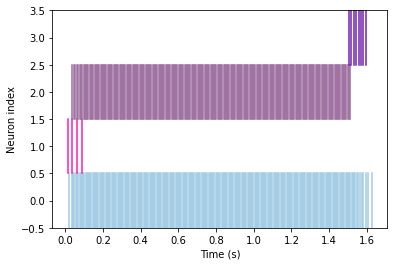

In [10]:
# ===== YOUR CODE HERE =====
net.simulate(2, 0.001) 
plot_spike_raster( net.all_spike_times() )

### (c)

inA puts the pair (A and B) into more active phase. inB puts the pair into more silent phase

## Q2: Local Excitation, Lateral Inhibition

### (a)

In [11]:
# ===== YOUR CODE HERE =====
N = 60
neuralList = [LIFNeuron(Tau_m=0.060, Tau_s=0.080) for _ in range(N)]
net = SpikingNetwork()
for i in range(0,N):
    net.add_neuron(neuralList[i])
    # connect to all other nodes
    for j in range(0,N):
        if abs(j-i)==1 or abs(j-i)==(N-1):
            net.connect(neuralList[i],neuralList[j],0.1)
        else:
            net.connect(neuralList[i],neuralList[j],-0.03)




### (b)

In [12]:
# ===== YOUR CODE HERE =====
#b
inputAll = InputNeuron( generate_spike_train([[0,25], [0.5,0]]))
net.add_neuron(inputAll)
weights = random_array(N)
for i in range(N):
    net.connect(inputAll, neuralList[i], weights[i])


### (c)

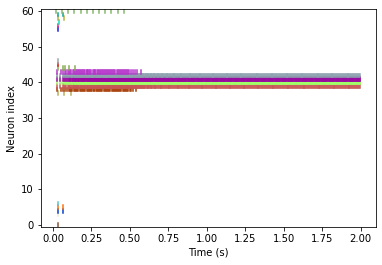

In [13]:
# ===== YOUR CODE HERE =====
#c
net.simulate(2, 0.001) 
plot_spike_raster( net.all_spike_times() )




### (d)
denote the neighbourhood as a set of neurons $C$, then $\sum_{n\in C}w(n,in)$ is large (where $in$ is the input neuron, $w(n,in)$ is connection weight of input neuron to neuron $n$).

in other words, the input neuron power the neighborhood into a active enough state that it stays active 




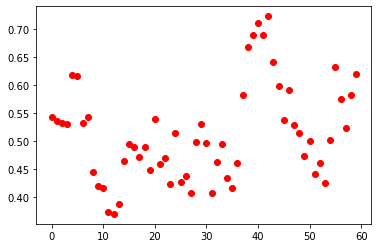

In [14]:
# ===== OPTIONAL CODE HERE =====
plt.plot(range(N),weights,'ro')